# Building Pipelines

Here we'll go into more detail on the Quick Start Example from [Getting Started](getting_started.rst). In this example, we'll build a pipeline that 

- standardized the input compositions to improve the convergence of the Gaussian Process optimization
- uses a Savitzky-Golay filter to compute the first derivative of the measurement
- computes the similarity between the derivatives of the measurement data
- clusters (i.e., labels) the data using spectral clustering
- fits a Gaussian Process classifier to the data.
- chooses the next optimal measurement based on the entropy of the Gaussian Process posterior 

Below are the imported modules used in this tutorial

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from AFL.double_agent import *
from AFL.double_agent.plotting import *

## Load Input Data

Okay, to begin, we'll load in a pre-prepared `xarray.Dataset`. These are powerful and flexible data structures for working with multi-dimensional data, and `AFL.double_agent` uses them for all input, intermediate and output data.

The dataset below contains simulated measurement data along with the compositions that this simulated data was generated at. It also has the ground truth phase labelse along with a grid of compositions that the agent will search through for the next optimal measurement. 

To see how this dataset is created, see [Building xarray.Datasets](../how-to/building_xarray_datasets>) page.


In [2]:
ds = xr.load_dataset('../data/example_dataset.nc')
ds

<xarray.Dataset> Size: 164kB
Dimensions:              (sample: 100, component: 2, x: 150, grid: 2500)
Coordinates:
  * component            (component) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.001 0.001047 0.001097 ... 0.9547 1.0
Dimensions without coordinates: sample, grid
Data variables:
    composition          (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels  (sample) int64 800B 1 1 0 1 0 1 1 1 ... 1 1 1 1 1 0 1 1
    measurement          (sample, x) float64 120kB 1.915e+06 1.479e+06 ... 1.885
    composition_grid     (grid, component) float64 40kB 0.0 0.0 ... 10.0 25.0

Note how, in the second column of the table,the dimension names of each variable is listed. This is a foundational feature of all xarray data structure and underlys how they error check and align operations.

## Step 1: Composition Preprocessing

Many machine learning and optimization algorithms show better performance when their input data is normalized or standardized (i.e., the data is rescaled so that the mean and standard deviation is small).

To start, we'll add Pipeline operations that normalize the  `composition` and  `composition_grid` data variables.



We'll do this using the `Pipeline` context manager (i.e., the `with` construct shown below). Using this approach, each `Pipeline` operation that is defined in the context is automatically added to the ``my_first_pipeline`` variable.

In [3]:
from AFL.double_agent import *

with Pipeline() as my_first_pipeline:
    Standardize(
        input_variable='composition',
        output_variable='normalized_composition',
        dim='sample',
        component_dim='component',
        min_val={'A':0.0,'B':0.0},
        max_val={'A':10.0,'B':25.0},
    )

my_first_pipeline

<Pipeline Pipeline N=1>

Going over the arguments to Standardize one by one:

- `input_variable='composition'`: The data variable to normalize, in this case the 'composition' variable
- `output_variable='normalized_composition': The name of the new variable that will store the normalized data
- `dim='sample'`: The dimension along which to compute statistics for normalization
- `component_dim='component'`: The dimension containing different components/features
- `min_val={'A':0.0,'B':0.0}`: Dictionary specifying minimum values for each component
- `max_val={'A':10.0,'B':25.0}`: Dictionary specifying maximum values for each component


We can view more information about the pipeline by printing it 

In [4]:
my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition

Input Variables
---------------
0) composition

Output Variables
----------------
0) normalized_composition


You can add more operations to the `Pipeline` by recreating the context

In [5]:
with my_first_pipeline:
    Standardize(
        input_variable='composition_grid',
        output_variable='normalized_composition_grid',
        dim='grid',
        component_dim='component',
        min_val={'A':0.0,'B':0.0},
        max_val={'A':10.0,'B':25.0},
    )

my_first_pipeline.print()


PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid

Input Variables
---------------
0) composition
1) composition_grid

Output Variables
----------------
0) normalized_composition
1) normalized_composition_grid


We can run the pipeline by calling the `.calculate` method and passing in the input dataset `ds`

In [6]:
ds_result = my_first_pipeline.calculate(ds);
ds_result

  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 205kB
Dimensions:                      (sample: 100, component: 2, x: 150, grid: 2500)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
Dimensions without coordinates: sample, grid
Data variables:
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0

Note that the output dataset `ds_result` contains not only all of the data from `ds` but also two new variables that were produced by the pipeline operations that we added: `normalized composition` and `normalized_composition_grid`.

We can visualise the results of the normalization by plotting the  `composition` and  `normalized_composition` variables side-by-side. We'll do this by using the `plot_scatter_mpl` helper function from `AFL.double_agent.plotting`.

[Text(0.5, 1.0, 'Normalized Composition Data')]

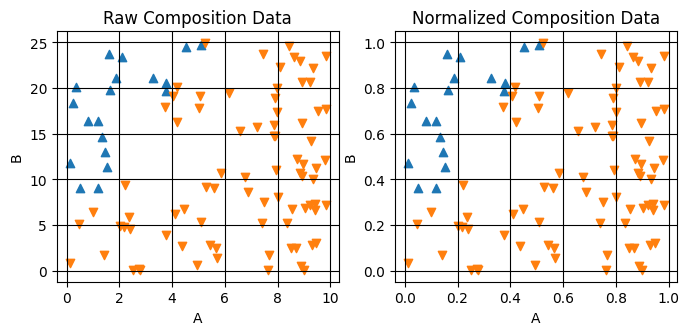

In [7]:
fig,axes = plt.subplots(1,2,figsize=(8,3.25))

plot_scatter_mpl(ds_result,'composition',component_dim='component',labels='ground_truth_labels',ax=axes[0])
axes[0].set(title='Raw Composition Data')

plot_scatter_mpl(ds_result,'normalized_composition',component_dim='component',labels='ground_truth_labels',ax=axes[1])
axes[1].set(title='Normalized Composition Data')


Note that the relative data positions are unchanged, only the magnitude of the axes is changed. 

## Step 2: Savitsky-Golay Filter

Now that we have the composition data processed, we can move on to processing the measurement data. In many cases, smoothing and filtering data can help remove noise and emphasize features in data that you want your agent to focus on. 

Here we'll add a `SavgolFilter` operation in order to calculate the first derivative of the measurement data. 

In [8]:
with my_first_pipeline:

       SavgolFilter(
           input_variable='measurement', 
           output_variable='derivative', 
           dim='x', 
           window_length=50,
           apply_log_scale=True,
           derivative=1,

           )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) normalized_composition
1) normalized_composition_grid
2) derivative




Let's go through each argument passed to SavgolFilter:

* `input_variable='measurement'`: Specifies the data variable to filter, in this case the raw measurement data
* `output_variable='derivative'`: Names the new variable that will store the filtered/derivative data
* `dim='x'`: Indicates which dimension to apply the filter along (the x-axis values)
* `window_length=50`: Sets the size of the moving window used for filtering - larger values give smoother results
* `apply_log_scale=True`: Takes the log of the x-axis values before filtering, useful for data spanning multiple orders of magnitude
* `derivative=1`: Calculates the first derivative of the data while filtering

We can run the pipeline on the dataset and plot the results.

In [9]:
ds_result = my_first_pipeline.calculate(ds)
ds_result

  0%|          | 0/3 [00:00<?, ?it/s]

<xarray.Dataset> Size: 407kB
Dimensions:                      (sample: 100, component: 2, x: 150,
                                  grid: 2500, log_x: 250)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
  * log_x                        (log_x) float64 2kB -3.0 -2.988 ... 0.0
Dimensions without coordinates: sample, grid
Data variables:
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0
    derivative                   (sample, log_x) float64 200kB -3.82 ... -0.4063

Now we can plot the results of the `Savgol` filter

[Text(0.5, 1.0, 'Derivative of Smoothed Log(Data)')]

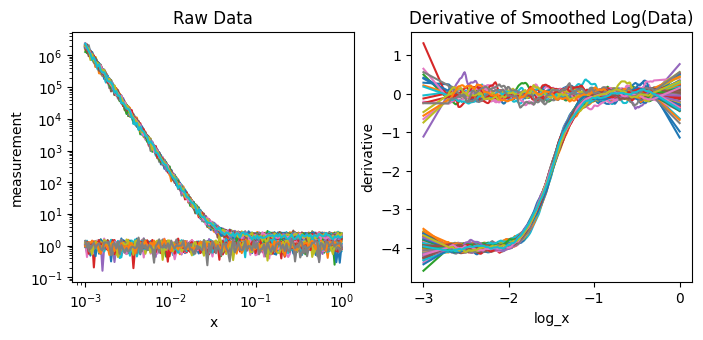

In [10]:
fig,axes = plt.subplots(1,2,figsize=(8,3.25))

ds_result.measurement.plot.line(x='x',xscale='log',yscale='log',ax=axes[0],add_legend=False)
ds_result.derivative.plot.line(x='log_x',ax=axes[1],add_legend=False);

axes[0].set(title="Raw Data")
axes[1].set(title="Derivative of Smoothed Log(Data)")

The data on the right has more flat, constant regions than the data on the left making it easier for the simlarity and clustering analyses below to separate. 

## Step 2: Calculate Similarity between Measurement Data

Now that we have preprocessed our data using the Savgol filter, we can calculate the similarity between different measurements. The `Similarity` component computes a similarity matrix between all pairs of samples based on their filtered derivative data. This similarity matrix will be used as input for clustering in the next step.


In [11]:
with my_first_pipeline:
    Similarity(
        input_variable='derivative', 
        output_variable='similarity', 
        sample_dim='sample',
        params={'metric': 'laplacian','gamma':1e-4}
        )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative
3  ) <SimilarityMetric>                  derivative ---> similarity

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) normalized_composition
1) normalized_composition_grid
2) similarity


The Similarity component takes the following inputs:

- `input_variable`: The variable to calculate similarity between ('derivative')
- `output_variable`: The variable to store the similarity matrix ('similarity')
- `sample_dim`: The dimension containing different samples ('sample')
- `params`: Dictionary of parameters for similarity calculation
  - `metric`: The similarity metric to use ('laplacian')
  - `gamma`: The scale parameter for the similarity metric (1e-4)

Let's execute the pipeline

In [12]:
ds_result = my_first_pipeline.calculate(ds)
ds_result

  0%|          | 0/4 [00:00<?, ?it/s]

<xarray.Dataset> Size: 487kB
Dimensions:                      (sample: 100, component: 2, x: 150,
                                  grid: 2500, log_x: 250, sample_i: 100,
                                  sample_j: 100)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
  * log_x                        (log_x) float64 2kB -3.0 -2.988 ... 0.0
Dimensions without coordinates: sample, grid, sample_i, sample_j
Data variables:
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0
    derivative                   (sample, log_x) float64 200kB -3.82 ... -0.4063
    similarity                   (sample_i, sample_j) float64 80kB 1.0 ... 1.0

We can visualize the similarity matrix. 

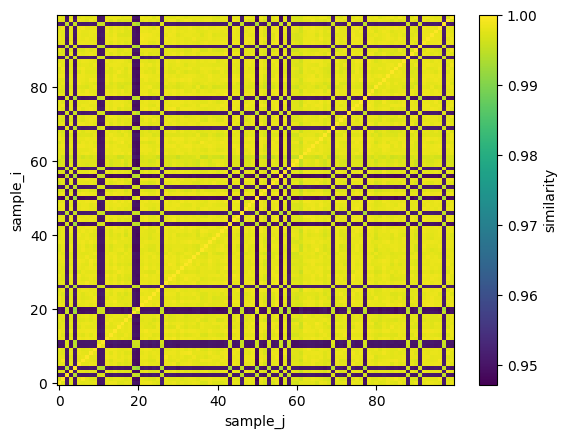

In [13]:
ds_result.similarity.plot()

Each pixel indexed by (i,j) in this image corresponds to the similarity between measurement i and j. The bright pixels indicate high similarity and the darker pixels reduced similarity. A check on this calculation is that the diagonal should have a perfect similarity = 1.0 because each data is perfectly self similar to itself, i.e. `S(i,i) = S(j,j) = 1.0`

## Step 3: Cluster Measurement Data based on Similarity

Now that we can use the similarity matrix to cluster the data into groups. 

In [14]:
with my_first_pipeline:
    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        params={'n_phases': 2}
        )


my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative
3  ) <SimilarityMetric>                  derivative ---> similarity
4  ) <SpectralClustering>                similarity ---> labels

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) normalized_composition
1) normalized_composition_grid
2) labels



The SpectralClustering pipeline operation takes:

 - `input_variable`: The similarity matrix to use for clustering ('similarity')
 - `output_variable`: The variable to store the cluster labels ('labels') 
 - `dim`: The dimension containing different samples ('sample')
 - `params`: Dictionary of parameters for clustering
   - `n_phases`: The number of clusters/phases to find (2)

Let's run the pipeline with this new operation

In [15]:
ds_result = my_first_pipeline.calculate(ds)
ds_result

  0%|          | 0/5 [00:00<?, ?it/s]

<xarray.Dataset> Size: 488kB
Dimensions:                      (sample: 100, component: 2, x: 150,
                                  grid: 2500, log_x: 250, sample_i: 100,
                                  sample_j: 100)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
  * log_x                        (log_x) float64 2kB -3.0 -2.988 ... 0.0
Dimensions without coordinates: sample, grid, sample_i, sample_j
Data variables:
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0
    derivative                   (sample, log_x) float64 200kB -3.82 ... -0.4063
    similarity                   (sample_i, sample_j) float64 80kB 1.0 ... 1.0
    labels                       (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1

Plotting the results of this labeling and comparing to the ground truth

[Text(0.5, 1.0, 'Spectral Clustering Labels')]

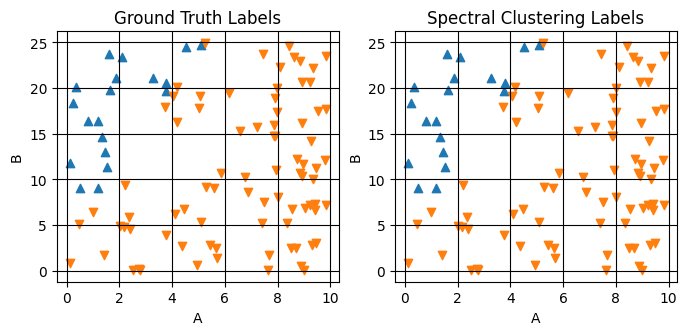

In [16]:

fig,axes = plt.subplots(1,2,figsize=(8,3.25))

plot_scatter_mpl(ds_result,'composition',component_dim='component',labels='ground_truth_labels',ax=axes[0])
plot_scatter_mpl(ds_result,'composition',component_dim='component',labels='labels',ax=axes[1])

axes[0].set(title="Ground Truth Labels")
axes[1].set(title="Spectral Clustering Labels")

## Step 4: Extrapolate Cluster Labels

Now we can extrapolate the labels from the `SpectralClustering` over the `composition_grid` that we supplied in the input dataset.

In [17]:
with my_first_pipeline:
    GaussianProcessClassifier(
        feature_input_variable='normalized_composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='normalized_composition_grid',
        grid_dim='grid',
    )
my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative
3  ) <SimilarityMetric>                  derivative ---> similarity
4  ) <SpectralClustering>                similarity ---> labels
5  ) <GaussianProcessClassifier>         ['normalized_composition', 'labels', 'normalized_composition_grid'] ---> ['extrap_mean', 'extrap_entropy']

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) extrap_mean
1) extrap_entropy


The GaussianProcessClassifier pipeline operation takes:

- `feature_input_variable`: The composition data to use for training ('compositions')
- `predictor_input_variable`: The labels to predict ('labels')
- `output_prefix`: Prefix for output variables ('extrap')
- `sample_dim`: The dimension containing different samples ('sample')
- `grid_variable`: The grid points to extrapolate to ('composition_grid')
- `grid_dim`: The dimension containing grid points ('grid')

In [18]:
ds_result = my_first_pipeline.calculate(ds)
ds_result

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.Dataset> Size: 548kB
Dimensions:                      (sample: 100, component: 2, x: 150,
                                  grid: 2500, log_x: 250, sample_i: 100,
                                  sample_j: 100)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
  * log_x                        (log_x) float64 2kB -3.0 -2.988 ... 0.0
Dimensions without coordinates: sample, grid, sample_i, sample_j
Data variables:
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0
    derivative                   (sample, log_x) float64 200kB -3.82 ... -0.4063
    similarity                   (sample_i, sample_j) float64 80kB 1.0 ... 1.0
    labels                       (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    extrap_mean                  (grid) int64 20kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    extrap_entropy               (grid) float64 20kB 0.5813 0.5687 ... 0.4603
    extrap_y_prob                (grid) float64 20kB 0.5813 0.5687 ... 0.4603

From this calculation, we get two new data variables: `extrap_y_entropy` and `extrap_mean`. These represent the most likely phase label and the entropy of this assignment. 

[Text(0.5, 1.0, 'Entropy of Phase Label')]

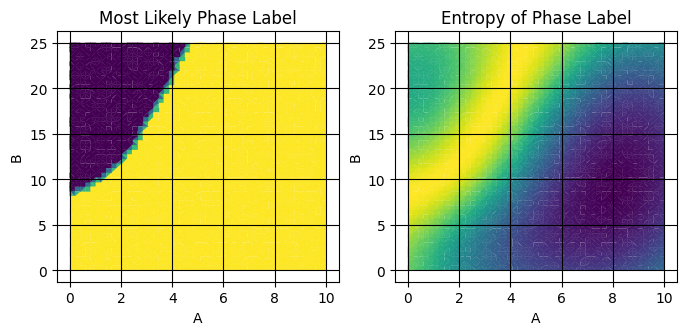

In [19]:
fig,axes = plt.subplots(1,2,figsize=(8,3.25))

plot_surface_mpl(ds_result,'composition_grid',component_dim='component',labels='extrap_mean',ax=axes[0])
plot_surface_mpl(ds_result,'composition_grid',component_dim='component',labels='extrap_entropy',ax=axes[1])

axes[0].set(title="Most Likely Phase Label")
axes[1].set(title="Entropy of Phase Label")

The right subplot is related to our confidence in the label prediction and is a powerful tool for finding label boundaries because, by construction, it is maximized at label boundaries. 

## Step 5: Calculate Next Sample

Now that we have a model that can predict phase labels and their uncertainty, we can use this information to select the next sample point. The `MaxValueAF` pipeline operation will select the composition with maximum entropy as the next point to measure, since high entropy indicates regions where the model is most uncertain about the phase label.


In [20]:
with my_first_pipeline:
    MaxValueAF(
        input_variables=['extrap_entropy'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative
3  ) <SimilarityMetric>                  derivative ---> similarity
4  ) <SpectralClustering>                similarity ---> labels
5  ) <GaussianProcessClassifier>         ['normalized_composition', 'labels', 'normalized_composition_grid'] ---> ['extrap_mean', 'extrap_entropy']
6  ) <MaxValueAF>                        ['extrap_entropy', 'composition_grid'] ---> next_sample

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) extrap_mean
1) next_sample


Let's run the pipeline

In [21]:
ds_result = my_first_pipeline.calculate(ds)
ds_result

  0%|          | 0/7 [00:00<?, ?it/s]

<xarray.Dataset> Size: 568kB
Dimensions:                      (sample: 100, component: 2, x: 150,
                                  grid: 2500, log_x: 250, sample_i: 100,
                                  sample_j: 100, AF_sample: 1)
Coordinates:
  * component                    (component) <U1 8B 'A' 'B'
  * x                            (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
  * log_x                        (log_x) float64 2kB -3.0 -2.988 ... 0.0
Dimensions without coordinates: sample, grid, sample_i, sample_j, AF_sample
Data variables: (12/14)
    composition                  (sample, component) float64 2kB 5.7 ... 5.104
    ground_truth_labels          (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    measurement                  (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid             (grid, component) float64 40kB 0.0 0.0 ... 25.0
    normalized_composition       (sample, component) float64 2kB 0.57 ... 0.2042
    normalized_composition_grid  (grid, component) float64 40kB 0.0 0.0 ... 1.0
    ...                           ...
    labels                       (sample) int64 800B 1 1 0 1 0 1 ... 1 1 1 0 1 1
    extrap_mean                  (grid) int64 20kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    extrap_entropy               (grid) float64 20kB 0.5813 0.5687 ... 0.4603
    extrap_y_prob                (grid) float64 20kB 0.5813 0.5687 ... 0.4603
    decision_surface             (grid) float64 20kB 0.7655 0.7391 ... 0.512
    next_sample                  (AF_sample, component) float64 16B 4.082 24.49

Let's plot the next composition on the mean and entropy plots:

[Text(0.5, 1.0, 'Entropy of Phase Label')]

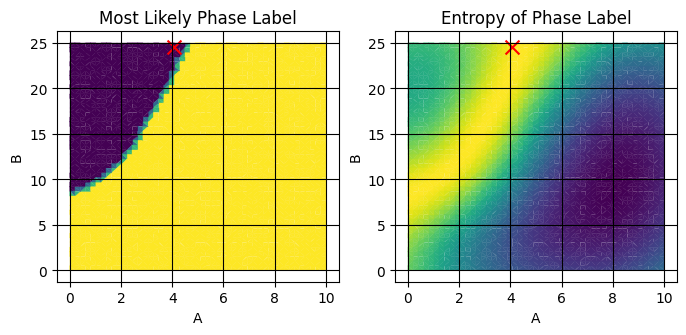

In [22]:
fig,axes = plt.subplots(1,2,figsize=(8,3.25))

plot_surface_mpl(ds_result,'composition_grid',component_dim='component',labels='extrap_mean',ax=axes[0])
plot_surface_mpl(ds_result,'composition_grid',component_dim='component',labels='extrap_entropy',ax=axes[1])

plot_scatter_mpl(ds_result,'next_sample',component_dim='component',labels=[-1],marker='x',color='red',s=100,ax=axes[0])
plot_scatter_mpl(ds_result,'next_sample',component_dim='component',labels=[-1],marker='x',color='red',s=100,ax=axes[1])

axes[0].set(title="Most Likely Phase Label")
axes[1].set(title="Entropy of Phase Label")

See that the red X is placed near the boundary of the two phases. Running the pipeline several times, you should see the X move about the bright region of entropy. This is because the `MaxValueAF` acquisition function doesn't choose the absolute maximum, but rather randomly chooses from the top `acquisition_rtol` percent of the entropy.

## Full Pipeline

With that, we have a full `Pipeline` which defines the behavior of a decision agent! Let's view the whole pipeline defined in a single context:

In [23]:
with Pipeline() as my_first_pipeline:

    Standardize(
        input_variable='composition',
        output_variable='normalized_composition',
        dim='sample',
        component_dim='component',
        min_val={'A':0.0,'B':0.0},
        max_val={'A':10.0,'B':25.0},
    )

    Standardize(
        input_variable='composition_grid',
        output_variable='normalized_composition_grid',
        dim='grid',
        component_dim='component',
        min_val={'A':0.0,'B':0.0},
        max_val={'A':10.0,'B':25.0},
    )

    SavgolFilter(
        input_variable='measurement', 
        output_variable='derivative', 
        dim='x', 
        derivative=1
        )

    Similarity(
        input_variable='derivative', 
        output_variable='similarity', 
        sample_dim='sample',
        params={'metric': 'laplacian','gamma':1e-4}
        )

    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        params={'n_phases': 2}
        )

    
    GaussianProcessClassifier(
        feature_input_variable='normalized_composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='normalized_composition_grid',
        grid_dim='grid',
    )

    MaxValueAF(
        input_variables=['extrap_entropy'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <Standardize>                       composition ---> normalized_composition
1  ) <Standardize>                       composition_grid ---> normalized_composition_grid
2  ) <SavgolFilter>                      measurement ---> derivative
3  ) <SimilarityMetric>                  derivative ---> similarity
4  ) <SpectralClustering>                similarity ---> labels
5  ) <GaussianProcessClassifier>         ['normalized_composition', 'labels', 'normalized_composition_grid'] ---> ['extrap_mean', 'extrap_entropy']
6  ) <MaxValueAF>                        ['extrap_entropy', 'composition_grid'] ---> next_sample

Input Variables
---------------
0) composition
1) composition_grid
2) measurement

Output Variables
----------------
0) extrap_mean
1) next_sample


We can also visualize the full pipeline using the `.draw` and `.draw_plotly` methods

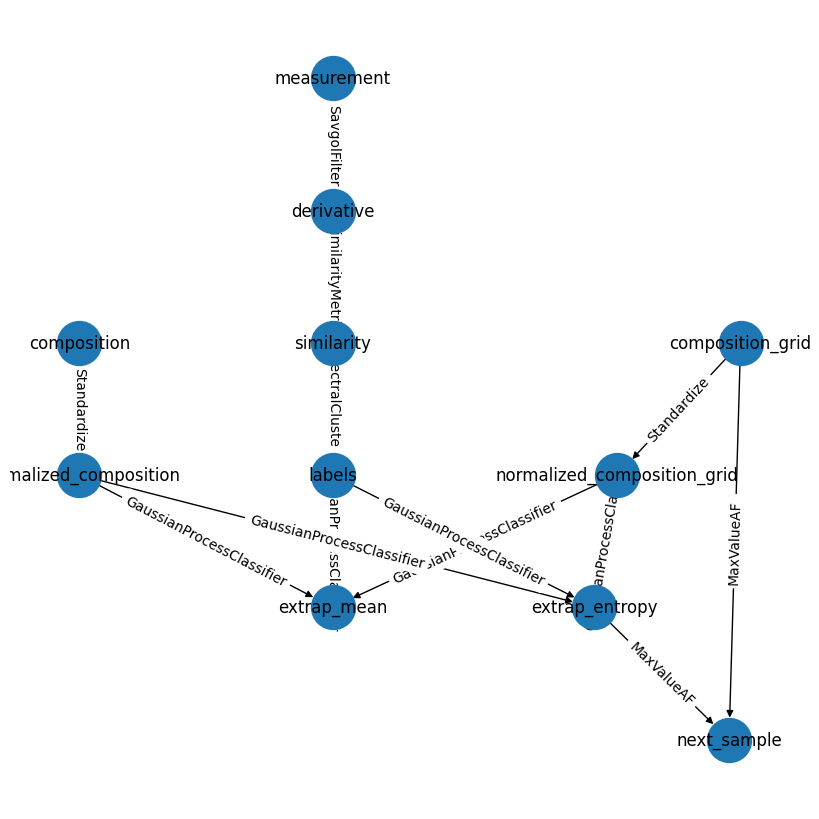

In [24]:
my_first_pipeline.draw();

While this doesn't always produce the more visually appealling graphs, it is a powerful way to check the consistency and flow of complex pipelines. 

# Conclusion

In this tutorial, we learned how to build pipelines in using `AFL.double_agent` by:

- Creating a new pipeline using `Pipeline()`
- Adding data processing steps like normalization and derivative calculation
- Implementing spectral clustering for phase identification
- Using Gaussian Process classification to extrapolate phase boundaries
- Adding active learning with acquisition functions to guide further sampling
- Visualizing the pipeline structure and results at each step

The pipeline we built demonstrates a complete workflow - from raw data processing through machine learning and active learning. This modular approach allows us to easily modify individual components while maintaining a clear data flow between steps.

For more examples of AFL pipelines and components, check out the other tutorials and examples in the documentation.

